**Appendix E – State Space Models**

_This notebook contains all the sample code in Appendix E._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/Appendix_E_state_space_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/Appendix_E_state_space_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

Are we using Colab or Kaggle?

In [2]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

And PyTorch ≥ 2.6.0:

In [3]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

Let's issue a warning if there's no hardware accelerator available:

In [6]:
if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Traditional SSMs

In [7]:
import torch

def zoh(A, B, dt):
    # extra code for the MPS device which does not support matrix exp
    device = A.device
    if device.type == "mps":
        A, B, dt = A.cpu(), B.cpu(), dt.cpu()

    d_state = A.size(-1)
    A_discrete = torch.matrix_exp(A * dt)
    Y = (A_discrete - torch.eye(d_state, device=A.device)) @ B
    B_discrete = torch.linalg.solve(A, Y)  # == torch.linalg.inv(A) @ Y

    # extra code for the MPS device which does not support matrix exp
    if device == "mps":
        A_discrete, B_discrete = A_discrete.to(device), B_discrete.to(device)

    return A_discrete, B_discrete

In [8]:
from scipy.linalg import logm

def inv_zoh(A_discrete, B_discrete, dt):
    d_state = A_discrete.size(-1)
    A_discrete_np = A_discrete.cpu().numpy()
    A_np = (1.0 / dt.item()) * logm(A_discrete_np)
    A = torch.tensor(A_np, dtype=A_discrete.dtype, device=A_discrete.device)
    Y = A @ B_discrete
    B = torch.linalg.solve(A_discrete - torch.eye(d_state, device=A.device), Y)
    return A, B

In [9]:
torch.manual_seed(42)
A = torch.randn(128, 128)
B = torch.randn(128, 17)
dt = torch.tensor(0.1)
A_discrete, B_discrete = zoh(A, B, dt)
A2, B2 = inv_zoh(A_discrete, B_discrete, dt)

mse_A = ((A - A2)**2).mean()
mse_B = ((B - B2)**2).mean()
mse_A.item(), mse_B.item()

(1.1793252138736499e-11, 4.045257018248094e-09)

In [10]:
import torch.nn as nn

class BasicSSM(nn.Module):
    def __init__(self, d_input, d_state, d_output):
        super().__init__()
        self.d_state = d_state
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Parameter(torch.randn(d_state, d_input))
        self.C = nn.Parameter(torch.randn(d_output, d_state))
        self.D = nn.Parameter(torch.randn(d_output, d_input))

    def forward(self, u):
        batch_size, seq_len, _ = u.shape
        h = torch.zeros(batch_size, self.d_state, device=u.device)
        outputs = []
        for i in range(seq_len):
            u_t = u[:, i, :]  # iterate over each element in the sequence
            h = h @ self.A.T + u_t @ self.B.T
            y = h @ self.C.T + u_t @ self.D.T
            outputs.append(y)

        return torch.stack(outputs, dim=1)

In [11]:
batch_size, seq_len, d_input = 32, 128, 64
d_state, d_output = 256, 64
ssm = BasicSSM(d_input, d_state, d_output)
X = torch.randn(batch_size, seq_len, d_input)
ssm(X).shape

torch.Size([32, 128, 64])

# Viewing Functions as Vectors

Show shifted Legendre polynomials:

In [12]:
from scipy.special import binom

def shifted_legendre_polynomial(i, x):
    coeffs = [(-1)**j * binom(i, j) * binom(i + j, i) for j in range(i + 1)]
    coeffs = (-1)**i * torch.tensor(coeffs, dtype=x.dtype)
    powers = x.unsqueeze(-1) ** torch.arange(i + 1, device=x.device)
    return (coeffs * powers).sum(dim=-1)

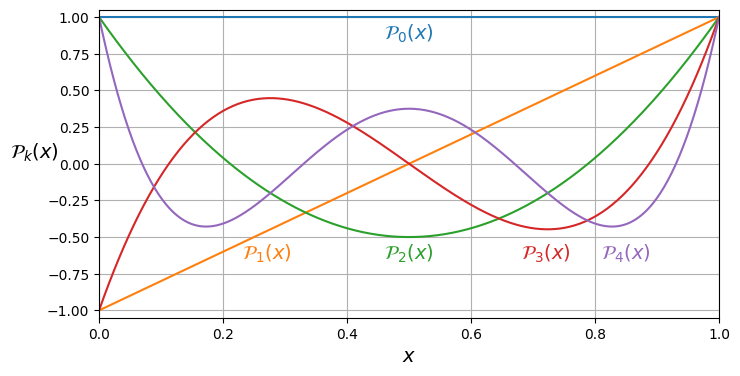

In [13]:
x = torch.linspace(0, 1, 500)
k_max = 5
plt.figure(figsize=(8, 4))
for k in range(k_max):
    y = shifted_legendre_polynomial(k, x)
    plt.plot(x, y)
    plt.grid(True)
    plt.axis([0, 1, -1.05, 1.05])
    plt.ylabel(r"$\mathcal{P}_k(x)$   ", rotation=0)
    plt.xlabel(r"$x$")

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.text(0.46, 0.85, r"$\mathcal{P}_0(x)$", color=colors[0])
plt.text(0.23, -0.65, r"$\mathcal{P}_1(x)$", color=colors[1])
plt.text(0.46, -0.65, r"$\mathcal{P}_2(x)$", color=colors[2])
plt.text(0.68, -0.65, r"$\mathcal{P}_3(x)$", color=colors[3])
plt.text(0.81, -0.65, r"$\mathcal{P}_4(x)$", color=colors[4])

plt.show()

In [14]:
def reconstructed_function(h, x):
    Pis = [shifted_legendre_polynomial(i, x) for i in range(h.size(0))]
    return (h.unsqueeze(-1) * torch.stack(Pis)).sum(dim=0)

In [15]:
torch.manual_seed(13)
max_weights = 11
weights = torch.randn(max_weights)
reconstructed_function(weights, x).shape

torch.Size([500])

# Legendre Memory Unit (LMU)

This code processes an input vector **u**<sub>_k_</sub> through multiple SSMs (one per input dimension) efficiently, for each instance in the batch:

In [16]:
batch_size, d_state, d_input = 64, 128, 32

A = torch.randn(1, 1, d_state, d_state)  # state-to-state matrix, shared by SSMs
B = torch.randn(1, 1, d_state, 1)  # input-to-state vector, shared by SSMs
H = torch.randn(batch_size, d_input, d_state, 1)  # state vector per inst. & SSM
u = torch.randn(batch_size, d_input, 1, 1)  # input scalar per instance & SSM

H = A @ H + B @ u  # update states of all SSMs across all instances, in parallel
y = H.view(batch_size, d_input * d_state)  # concat. outputs for all instances

In [17]:
H.shape

torch.Size([64, 32, 128, 1])

In [18]:
y.shape

torch.Size([64, 4096])

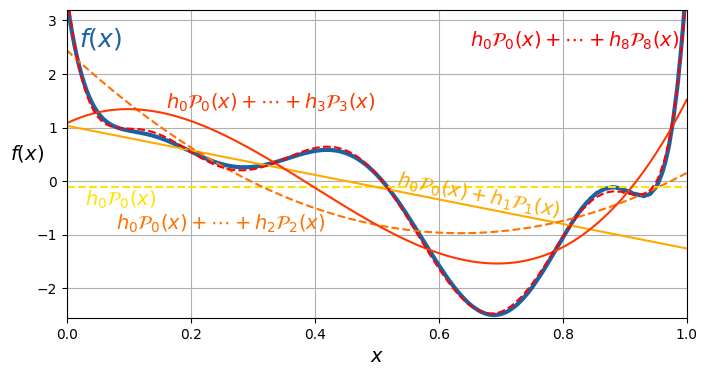

In [19]:
cmap = plt.colormaps["autumn_r"]
n_curves = 4
colors = [cmap((i + 0.5) / (n_curves + 0.5)) for i in range(n_curves + 1)]
f_color = "#1b62a3"

plt.figure(figsize=(8, 4))

u = reconstructed_function(weights, x)
plt.plot(x, u, linewidth=3, color=f_color)


for k in range(n_curves + 1):
    selected_weights = (weights[:max_weights - 2] if k == n_curves
                        else weights[: k + 1])
    y = reconstructed_function(selected_weights, x)
    plt.plot(x, y, color=colors[k], linestyle="-" if k % 2 == 1 else "--")
    plt.xlabel("$x$")
    plt.ylabel(r"$f(x)$  ", rotation=0)
    plt.grid(True)

plt.axis([0, 1, -2.55, 3.2])
plt.text(0.03, -0.45, r"$h_0\mathcal{P}_0(x)$", color=colors[0])
plt.text(0.53, -0.67, r"$h_0\mathcal{P}_0(x) + h_1\mathcal{P}_1(x)$",
         color=colors[1], rotation=-11)
plt.text(0.08, -0.91, r"$h_0\mathcal{P}_0(x) + ⋯ + h_2\mathcal{P}_2(x)$",
         color=colors[2])
plt.text(0.16, 1.36, r"$h_0\mathcal{P}_0(x) + ⋯ + h_3\mathcal{P}_3(x)$",
         color=colors[3])
plt.text(0.65, 2.52, r"$h_0\mathcal{P}_0(x) + ⋯ + h_8\mathcal{P}_8(x)$",
         color=colors[4])
plt.text(0.02, 2.52, r"$f(x)$", color=f_color, fontsize=18)

plt.show()

# The HiPPO Framework

Legendre (scaled) transition matrices:

In [20]:
def legs(d_state):
    q = torch.arange(d_state, dtype=torch.float32)
    col, row = torch.meshgrid(q, q, indexing='xy')
    r = 2 * q + 1
    M = -(torch.where(row >= col, r.unsqueeze(0).expand(d_state, d_state),
                      torch.zeros(d_state, d_state)) - torch.diag(q))
    T = torch.sqrt(torch.diag(2 * q + 1))
    A = T @ M @ torch.linalg.inv(T)
    B = torch.diag(T).unsqueeze(1)
    return A, B

In [21]:
A, B = legs(3)
A

tensor([[-1.0000,  0.0000,  0.0000],
        [-1.7321, -2.0000,  0.0000],
        [-2.2361, -3.8730, -3.0000]])

In [22]:
B

tensor([[1.0000],
        [1.7321],
        [2.2361]])

Legendre (translated) transition matrices:

In [23]:
def legt(d_state):
    Q = torch.arange(d_state, dtype=torch.float32)
    R = (2 * Q + 1) ** 0.5
    j, i = torch.meshgrid(Q, Q, indexing='xy')
    A = R.unsqueeze(1) * torch.where(i < j, (-1.)**(i - j),
                                     torch.ones_like(i)) * R.unsqueeze(0)
    B = R.unsqueeze(1)
    return -A * 0.5, B * 0.5

In [24]:
A, B = legt(3)
A

tensor([[-0.5000,  0.8660, -1.1180],
        [-0.8660, -1.5000,  1.9365],
        [-1.1180, -1.9365, -2.5000]])

In [25]:
B

tensor([[0.5000],
        [0.8660],
        [1.1180]])

Laguerre (translated) transition matrices:

In [26]:
def lagt(d_state, beta=1.0):
    ones = torch.ones((d_state, d_state))
    A = torch.eye(d_state) / 2 - torch.tril(ones)
    B = beta * ones[:, 1]
    return A, B

In [27]:
A, B = lagt(3)
A

tensor([[-0.5000,  0.0000,  0.0000],
        [-1.0000, -0.5000,  0.0000],
        [-1.0000, -1.0000, -0.5000]])

In [28]:
B

tensor([1., 1., 1.])

# The Convolutional Representation of LTI SSMs

Let's generate Figure E-9:

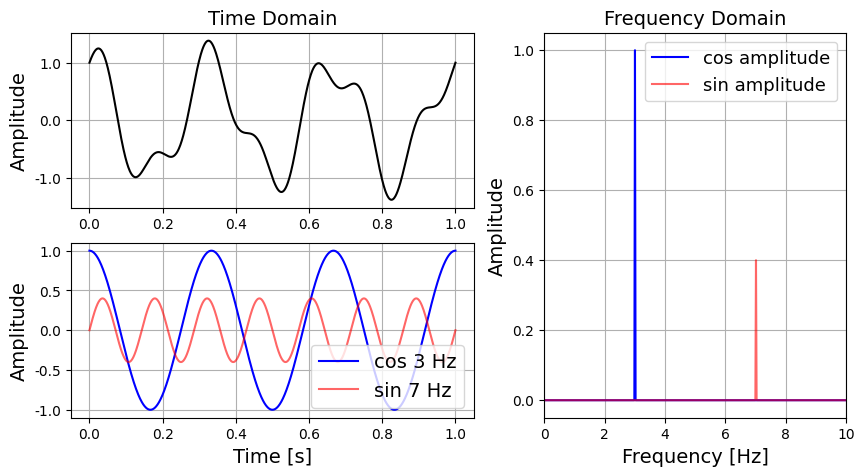

In [29]:
import matplotlib as mpl

t = torch.linspace(0, 1, 1000)
cos_freq, cos_magnitude = 3, 1.0
sin_freq, sin_magnitude = 7, 0.4
cos_wave = cos_magnitude * torch.cos(2 * torch.pi * cos_freq * t)
sin_wave = sin_magnitude * torch.sin(2 * torch.pi * sin_freq * t)
combined = cos_wave + sin_wave

fig = plt.figure(figsize=(10, 5))

gs = fig.add_gridspec(2, 2, width_ratios=[2, 1.5])
ax_left_top = fig.add_subplot(gs[0, 0])
ax_left_bottom = fig.add_subplot(gs[1, 0], sharex=ax_left_top)
ax_right_mag = fig.add_subplot(gs[:, 1])

ax_left_top.plot(t, combined, color='black')
ax_left_top.grid(True)
ax_left_top.set_title('Time Domain')
ax_left_top.set_ylabel('Amplitude')

ax_left_bottom.plot(t, cos_wave, label=f'cos {cos_freq} Hz', color="blue")
ax_left_bottom.plot(t, sin_wave, label=f'sin {sin_freq} Hz', color="red", alpha=0.6)
ax_left_bottom.grid(True)
ax_left_bottom.set_xlabel('Time [s]')
ax_left_bottom.set_ylabel('Amplitude')
ax_left_bottom.legend(loc="lower right")

ax_left_top.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax_left_bottom.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

N = 500
max_freq = 10
freqs = torch.linspace(0, max_freq, N)
cos_magnitudes = torch.zeros(N)
sin_magnitudes = torch.zeros(N)
cos_magnitudes[int(cos_freq / max_freq * N)] = cos_magnitude
sin_magnitudes[int(sin_freq / max_freq * N)] = sin_magnitude

ax_right_mag.plot(freqs, cos_magnitudes, color="blue", label="cos amplitude")
ax_right_mag.plot(freqs, sin_magnitudes, color="red", label="sin amplitude", alpha=0.6)

ax_right_mag.set_xlim(0, 10)
ax_right_mag.grid(True)
ax_right_mag.set_title('Frequency Domain')
ax_right_mag.set_xlabel('Frequency [Hz]')
ax_right_mag.set_ylabel('Amplitude')
ax_right_mag.legend(fontsize=13)

plt.show()

And this is how to actually apply the Fast Fourier Transform:

In [30]:
freqs = torch.fft.rfftfreq(len(t), d=t[1]-t[0])
F = torch.fft.rfft(combined) / len(t)
cos_magnitudes = 2 * torch.real(F)
sin_magnitudes = -2 * torch.imag(F)

Now let's write a couple functions to perform the same convolution in the time domain and in the frequency domain:

In [31]:
import torch.nn.functional as F
from torch.fft import rfft, irfft

def convolution_in_time_domain(k, u):
    B, d, L = u.shape  # B = batch size, d = input/output dim, L = seq. length
    u_padded = F.pad(u, (L - 1, 0))  # pad left; shape (B, d, L + L - 1)
    k_flipped = k.flip(dims=[-1]).unsqueeze(1)  # shape (d, 1, L)
    y = F.conv1d(u_padded, k_flipped, groups=d)  # shape (d, 1, L)
    return y

def convolution_in_frequency_domain(k, u):
    B, d, L = u.shape
    n = L + L - 1
    u_f = rfft(u, n=n)  # shape (B, d, n)
    k_f = rfft(k, n=n)  # shape (B, d, n)
    y_f = u_f * k_f.unsqueeze(0)  # shape (B, d, n)
    y = irfft(y_f, n=n)[..., :L]  # shape (B, d, L)
    return y

In [32]:
torch.manual_seed(42)
B, d_input, L = 32, 8, 512
u = torch.randn(B, d_input, L).to(device)
k = torch.randn(d_input, L).to(device)
result1 = convolution_in_time_domain(k, u)
result2 = convolution_in_frequency_domain(k, u)
mse = ((result1 - result2) ** 2).mean()
mse

tensor(6.3313e-11, device='cuda:0')

# Mamba

To get the best speed, we need the fused GPU kernel for the Mamba SSM (discussed in the book), as well as a GPU kernel for the causal 1D convolution used in the Mamba block. For the former, we need the mamba-ssm library, which is only available on Linux, using an NVIDIA GPU with CUDA 11.6+. For the latter, we can install the causal-conv1d library.

If you are running this notebook on your own Linux machine with a CUDA 11.6+ GPU, you must install these libraries manually. If you followed the [installation instructions](https://github.com/ageron/handson-mlp/blob/main/INSTALL.md), then you are using the `uv` package manager: in this case, you must open a terminal, activate the virtual environment for this project, and run `uv pip install causal-conv1d` and `uv pip install mamba-ssm`. The packages will be built from source, which will require the essential tools for building a C++ project, as well as the CUDA toolkit.

Unfortunately, when you install these packages using `pip install causal-conv1d` and `pip install mamba-ssm`, they are built from source, which takes over two hours on Colab! To spare you this long wait, I built the wheels and made them available via Google Drive:

In [33]:
if (IS_COLAB or IS_KAGGLE) and device == "cuda":
    %pip -q install https://homl.info/causal_conv1d-1.5.3.post1-cp312-cp312-linux_x86_64.whl
    %pip -q install https://homl.info/mamba_ssm-2.2.6.post3-cp312-cp312-linux_x86_64.whl

**WARNING**: Never install a binary package from a source you don't trust. If you prefer to install the packages the normal way, just run the following commands (it will take a couple of hours):

```
%pip install causal-conv1d
%pip install mamba-ssm
```

A pretrained Mamba model can be downloaded using the Hugging Face Transformers library, and used to generate text exactly like transformer models:

In [34]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "state-spaces/mamba-790m-hf"  # or mamba-2.8b if it fits on your GPU
model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
input_text = "State space models are"
inputs = tokenizer(input_text, return_tensors="pt")
outputs = model.generate(**inputs, max_length=50)  # the usual generation API
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.17G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

State space models are used to model the dynamics of the system. The state space model is a system of ordinary differential equations (ODEs) that describe the evolution of the system over time. The state space model is a system of ODEs


If you want to create your own custom Mamba model and train it from scratch, you can create a custom `MambaConfig` object and create a `MambaForCausalLM` model based on this config, for example:

In [35]:
from transformers import MambaConfig, MambaForCausalLM

custom_config = MambaConfig(  # a tiny toy Mamba model
    vocab_size=1000,
    hidden_size=64,  # d_model
    num_hidden_layers=4,  # number of Mamba blocks
    state_size=8,  # d_state
    conv_kernel_size=4,  # the Conv1d layer's kernel size
    expansion_factor=2,  # the expansion factor E
)
tiny_mamba = MambaForCausalLM(config=custom_config)

If you want full control, you can build your own models based on the `Mamba` and `Mamba2` blocks (this requires the mamba-ssm library):

In [36]:
try:
    from mamba_ssm import Mamba  # or Mamba2

    mamba_block = Mamba(d_model=64, d_state=16, d_conv=4, expand=2).to(device)
    X = torch.randn(8, 128, 64).to(device)
    y_pred = mamba_block(X)  # shape: [8, 128, 64]
    print(y_pred.shape)
except ImportError:
    print("The mamba-ssm library is not installed")

torch.Size([8, 128, 64])


# Extra Material – Transition Matrices for Various HiPPO Methods

Note: I adapted the following code from https://github.com/state-spaces/s4/blob/main/src/models/hippo/hippo.py:

This code creates the transition matrices for various HiPPO methods.

In [37]:
import numpy as np
from scipy.special import binom, gammaln

def lagt(N, beta=1.0):
    """Laguerre (translated) transition matrices."""
    A = torch.eye(N) / 2 - torch.tril(torch.ones((N, N)))
    B = beta * torch.ones((N, 1))
    return A, B


def tlagt(N, beta=1.0):
    """Tilted Laguerre (translated) transition matrices.
    beta = 1 corresponds to no tilt.
    """
    A = (1. - beta) / 2 * torch.eye(N) - torch.tril(torch.ones((N, N)))
    B = beta * torch.ones((N, 1))
    return A, B


def glagt(N, alpha=0.0, beta=0.01):
    """Generalized Laguerre transition matrices.
    alpha 0, beta small is most stable (limits to the 'lagt' measure).
    alpha 0, beta 1 has transition matrix A = [lower triangular 1].

    Note: Uses NumPy/SciPy for special functions (binom, gammaln).
    """
    A = -np.eye(N) * (1 + beta) / 2 - np.tril(np.ones((N, N)), -1)
    B = binom(alpha + np.arange(N), np.arange(N))[:, None]

    L = np.exp(.5 * (gammaln(np.arange(N) + alpha + 1) - gammaln(np.arange(N) + 1)))
    A = (1. / L[:, None]) * A * L[None, :]
    B = (1. / L[:, None]) * B * np.exp(-.5 * gammaln(1 - alpha)) * beta**((1 - alpha) / 2)

    A = torch.from_numpy(A).float()
    B = torch.from_numpy(B).float()
    return A, B


def legt(N):
    """Legendre (translated) transition matrices."""
    Q = torch.arange(N, dtype=torch.float32)
    R = (2 * Q + 1) ** .5
    j, i = torch.meshgrid(Q, Q, indexing='xy')
    A = R.unsqueeze(1) * torch.where(i < j, (-1.)**(i - j), torch.ones_like(i)) * R.unsqueeze(0)
    B = R.unsqueeze(1)
    A = -A

    # Halve again for timescale correctness
    A *= 0.5
    B *= 0.5
    return A, B


def lmu(N):
    """LMU: equivalent to LegT up to normalization."""
    Q = torch.arange(N, dtype=torch.float32)
    R = (2 * Q + 1).unsqueeze(1)
    j, i = torch.meshgrid(Q, Q, indexing='xy')
    A = torch.where(i < j, -torch.ones_like(i), (-1.)**(i - j + 1)) * R
    B = (-1.)**Q.unsqueeze(1) * R
    return A, B


def legs(N):
    """Legendre (scaled) transition matrices."""
    q = torch.arange(N, dtype=torch.float32)
    col, row = torch.meshgrid(q, q, indexing='xy')
    r = 2 * q + 1
    M = -(torch.where(row >= col, r.unsqueeze(0).expand(N, N), torch.zeros(N, N)) - torch.diag(q))
    T = torch.sqrt(torch.diag(2 * q + 1))
    A = T @ M @ torch.linalg.inv(T)
    B = torch.diag(T).unsqueeze(1)
    return A, B


def legsd(N):
    """Legendre (scaled, variant) transition matrices."""
    q = torch.arange(N, dtype=torch.float32)
    col, row = torch.meshgrid(q, q, indexing='xy')
    r = 2 * q + 1
    M = -(torch.where(row >= col, r.unsqueeze(0).expand(N, N), torch.zeros(N, N)) - torch.diag(q))
    T = torch.sqrt(torch.diag(2 * q + 1))
    A = T @ M @ torch.linalg.inv(T)
    B = torch.diag(T).unsqueeze(1)
    A += .5 * B * B.transpose(0, 1)
    B = B / 2.0
    return A, B


def fourier_diag(N):
    """Fourier (diagonal variant) transition matrices."""
    assert N % 2 == 0
    freqs = torch.arange(N // 2, dtype=torch.float32)
    d = torch.stack([freqs, torch.zeros(N // 2)], dim=-1).reshape(-1)[:-1]
    A = 2 * torch.pi * (-torch.diag(d, 1) + torch.diag(d, -1))
    A = A - .5 * torch.eye(N)
    B = torch.zeros(N)
    B[0::2] = 2**.5
    B[0] = 1
    B = B.unsqueeze(1)
    return A, B


def fourier(N):
    """Fourier transition matrices."""
    assert N % 2 == 0
    freqs = torch.arange(N // 2, dtype=torch.float32)
    d = torch.stack([torch.zeros(N // 2), freqs], dim=-1).reshape(-1)[1:]
    A = torch.pi * (-torch.diag(d, 1) + torch.diag(d, -1))
    B = torch.zeros(N)
    B[0::2] = 2**.5
    B[0] = 1

    # Subtract off rank correction - this corresponds to the other endpoint u(t-1)
    A = A - B.unsqueeze(1) * B.unsqueeze(0)
    B = B.unsqueeze(1)
    return A, B


def fourier_decay(N):
    """Fourier (with decay) transition matrices."""
    assert N % 2 == 0
    freqs = torch.arange(N // 2, dtype=torch.float32)
    d = torch.stack([torch.zeros(N // 2), freqs], dim=-1).reshape(-1)[1:]
    A = torch.pi * (-torch.diag(d, 1) + torch.diag(d, -1))
    B = torch.zeros(N)
    B[0::2] = 2**.5
    B[0] = 1

    # Subtract off rank correction - this corresponds to the other endpoint u(t-1)
    A = A - .5 * B.unsqueeze(1) * B.unsqueeze(0)
    B = .5 * B.unsqueeze(1)
    return A, B


def fourier2(N):
    """Fourier (double frequency): orthonormal on [0, 1]."""
    assert N % 2 == 0
    freqs = 2 * torch.arange(N // 2, dtype=torch.float32)
    d = torch.stack([torch.zeros(N // 2), freqs], dim=-1).reshape(-1)[1:]
    A = torch.pi * (-torch.diag(d, 1) + torch.diag(d, -1))
    B = torch.zeros(N)
    B[0::2] = 2**.5
    B[0] = 1

    # Subtract off rank correction - this corresponds to the other endpoint u(t-1)
    A = A - B.unsqueeze(1) * B.unsqueeze(0) * 2
    B = B.unsqueeze(1) * 2
    return A, B


def random_transition(N):
    """Random transition matrices."""
    A = torch.randn(N, N) / N
    B = torch.randn(N, 1)
    return A, B


def diagonal_transition(N):
    """Diagonal transition matrices."""
    A = -torch.diag(torch.exp(torch.randn(N)))
    B = torch.randn(N, 1)
    return A, B

In [38]:
N = 4
methods = [diagonal_transition, fourier_decay, fourier_diag, fourier, fourier2,
           glagt, lagt, legs, legsd, legt, lmu, random_transition, tlagt]
for method in methods:
    A, B = method(N)
    print("-" * 80)
    print(method.__name__)
    print("A =")
    print(A)
    print("B =")
    print(B)
    print()

--------------------------------------------------------------------------------
diagonal_transition
A =
tensor([[-2.9935, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.2566, -0.0000, -0.0000],
        [-0.0000, -0.0000, -1.3633, -0.0000],
        [-0.0000, -0.0000, -0.0000, -1.3772]])
B =
tensor([[ 0.2195],
        [-0.1543],
        [-0.3843],
        [ 1.0100]])

--------------------------------------------------------------------------------
fourier_decay
A =
tensor([[-0.5000,  0.0000, -0.7071,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7071,  0.0000, -1.0000, -3.1416],
        [ 0.0000,  0.0000,  3.1416,  0.0000]])
B =
tensor([[0.5000],
        [0.0000],
        [0.7071],
        [0.0000]])

--------------------------------------------------------------------------------
fourier_diag
A =
tensor([[-0.5000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.5000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.5000, -6.2832],
        [ 0.0000,  0.0000,  6.